In [498]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import geopandas as gpd
import math
import numpy as np
import chardet
import plotly.express as px

%matplotlib inline

### Exploration of the crime statistics of the city of London

Eventually, the plan is to implement a system that provides a quick evaluation and comparison between different neighbourhoods of London in terms of life quality and affordability. This particular module will implement a functionality where entering a specific neighbourhood's zip code will return crime levels at the LSOA, Ward and Borough level. These levels should be compared  with the average levels of crime in the city. This information will be then plugged into a bigger model that will evaluate this and other aspects of the specified neighbourhood.

For the moment, I have highlighted the following crimes as important for somebody choosing their residence:
* **Violence Against the Person:** Homicide
* **Violence Against the Person:** Violence with Injury
* **Violence Against the Person:** Violence with Injury
* **Burglary:**	Burglary - Residential
* **Sexual Offences:** Other Sexual Offences
* **Sexual Offences:** Rape


In [ ]:
# Collected information about the employed datasets

# File paths
fp_data = 'datasets/'
fp_maps = 'datasets/maps/'

# Data from: https://data.london.gov.uk/dataset/recorded_crime_summary
fp_crime_LSOA = 'MPS LSOA Level Crime (most recent 24 months).csv'
fp_crime_Ward = 'MPS Ward Level Crime (most recent 24 months).csv'
fp_crime_Borough = 'MPS Borough Level Crime (most recent 24 months).csv'

# Data from: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
fp_map_Borough = "London_Borough_Excluding_MHW.shp"

# Data from: https://data.london.gov.uk/dataset/london-borough-profiles
fp_profile_Borough = 'london-borough-profiles.csv'

In [434]:
def sum_all_crimes(all_crimes, location_column, crimes_of_interest, exclude=None):
    
    """
    Sums up all crimes of interest for each location in the data
    
    all_crimes         -- data frame with crimes and locations
    location_column    -- string with the name of the location column (e.g., "WardName")
    crimes_of_interest -- list of strings containing crimes to include in the sum
    exclude            -- a string or list of strings specifying locations to exclude
    
    Returns a data frame with locations and numbers of all crimes
    """
    
    # Select only crimes of interest
    crimes = all_crimes[all_crimes['MinorText'].isin(crimes_of_interest)].copy()
    
    # Select and exclude the specified locations for analysis
    locations = crimes[location_column].unique()
    if exclude:
        if isinstance(exclude,str):
            exclude = [exclude]
        for ex in exclude:
            locations = locations[locations != ex]
    
    # Sum up each location's crimes over the past 12 months
    num_crimes = np.zeros((len(locations),))
    for i, location in enumerate(locations):
        crimes_at_location = crimes[crimes[location_column] == location]
        num_crimes[i] = crimes_at_location[crimes_at_location.columns[17:17+12]].sum(axis=1).sum()
        
    # Return the results as a data frame
    return pd.DataFrame(data = {location_column:locations, "number_of_crimes":num_crimes}).set_index(location_column)


In [488]:
def crimes_per_capita(crimes_df, pop_df, location_column, pop_column):
    
    """
    Calculates crimes per people
    
    crimes_df        -- data frame with locations and 'number of crimes' in that location
    pop_df           -- data frame with locations' population data
    location_column  -- string with the name of the location column (e.g., "WardName")
    
    Returns a data frame with locations and crimes per capita
    """
    
    locations = crimes_df.index.values
    crimes_per_capita = np.zeros((len(locations),))
    
    for i, location in enumerate(locations):        
        pop = pop_df[pop_df[location_column] == location][pop_column].values[0]
        crimes_per_capita[i] = crimes_df.loc[location,'number_of_crimes'] / pop
        
    # Return the results as a data frame
    return pd.DataFrame(data = {location_column:locations, "crimes_per_capita":crimes_per_capita}).set_index(location_column)
    

In [446]:
def load_dataset(filename, filepath='datasets/'):
    
    """
    Detects encoding of the specified dataset and loads it as a data frame
    
    """
    
    # Check the encoding using 'chardet' libary
    rawdata = open(filepath + filename, 'rb').read()
    result = chardet.detect(rawdata)
    encod = result['encoding']
    
    return pd.read_csv(filepath + filename, encoding=encod)
    

In [482]:
# Load the data
crime_Borough_df = pd.read_csv(fp_data + fp_crime_Borough)
crime_Borough_df.rename(columns={"LookUp_BoroughName":"BoroughName"}, inplace=True)

profile_Borough_df = load_dataset(filename=fp_profile_Borough)
profile_Borough_df.rename(columns={"Area_name":"BoroughName"}, inplace=True)

In [483]:
profile_Borough_df.head()

,Code,BoroughName,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015",...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,...,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,78188,"3,611",57.9,32.9,27.2,63.1,...,7.1,3.1,28.5,7.3,228,Lab,0,100,0,36.5
2,E09000003,Barnet,Outer London,389600,151423,"8,675",44.9,37.3,21.1,64.9,...,7.4,2.8,20.7,6.0,134,Cons,50.8,.,1.6,40.5
3,E09000004,Bexley,Outer London,244300,97736,"6,058",40.3,39.0,20.6,62.9,...,7.2,3.3,22.7,6.9,164,Cons,71.4,23.8,0,39.6
4,E09000005,Brent,Outer London,332100,121048,"4,323",76.8,35.6,20.9,67.8,...,7.2,2.9,24.3,7.9,169,Lab,9.5,88.9,1.6,36.3


In [484]:
crime_Borough_df.head()

,MajorText,MinorText,BoroughName,201708,201709,201710,201711,201712,201801,201802,...,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907
0,Arson and Criminal Damage,Arson,Barking and Dagenham,5,8,7,7,4,2,3,...,8,5,1,5,2,5,5,11,3,5
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,169,134,132,108,119,135,111,...,131,105,88,97,127,137,130,138,114,118
2,Burglary,Burglary - Business and Community,Barking and Dagenham,30,25,23,27,21,38,33,...,32,39,33,44,24,29,27,22,27,29
3,Burglary,Burglary - Residential,Barking and Dagenham,83,81,122,88,124,143,134,...,94,106,164,114,107,99,96,114,96,71
4,Drug Offences,Drug Trafficking,Barking and Dagenham,1,6,7,5,6,4,5,...,6,7,2,5,1,6,4,8,6,7


In [490]:
crimes_of_interest = [
    'Homicide',
    'Violence with Injury',
    'Violence without Injury',
    'Robbery of Personal Property',
    'Burglary - Residential',
    'Other Sexual Offences',
    'Rape']

Borough_crimes = sum_all_crimes(crime_Borough_df,
                                'BoroughName',
                                crimes_of_interest,
                                exclude='London Heathrow and London City Airports')

Borough_crimesPerCapita = crimes_per_capita(crimes_df = Borough_crimes,
                                            pop_df = profile_Borough_df,
                                            location_column = 'BoroughName',
                                            pop_column = 'GLA_Population_Estimate_2017')

Borough_crimesPerCapita.head()

,crimes_per_capita
BoroughName,
Barking and Dagenham,0.035483
Barnet,0.025236
Bexley,0.024347
Brent,0.032213
Bromley,0.023626


In [493]:
map_Borough = gpd.read_file(fp_maps + fp_map_Borough)
map_Borough = map_Borough.set_index('NAME').join(Borough_crimesPerCapita)

In [494]:
map_Borough.head(5)

,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,crimes_per_capita
NAME,,,,,,,,
Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",0.023974
Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",0.029899
Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",0.023626
Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",0.031565
Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",0.029326


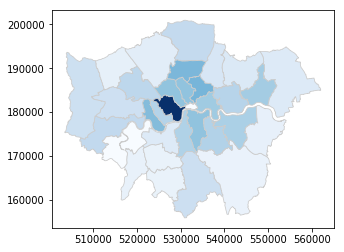

In [507]:
cmap = matplotlib.cm.get_cmap(name='Blues')
cmap.set_bad(color='red')

map_Borough.plot(column="crimes_per_capita", cmap=cmap, linewidth=0.8, edgecolor='0.8')